In [352]:
%matplotlib inline

In [353]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import simpy

In [354]:
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

In [355]:
# Load the pickle files for policies
with open('pickles/original_q_table.pkl', 'rb') as f:
    original_q = pickle.load(f)
with open('pickles/enhanced_q_table.pkl', 'rb') as f:
    enhanced_q = pickle.load(f)

original_q, enhanced_q

({(np.int32(1),
   np.int32(0),
   np.int32(0)): array([-255.5825304 , -251.41905634]),
  (np.int32(0),
   np.int32(0),
   np.int32(0)): array([-223.14969755, -220.16629677]),
  (np.int32(0),
   np.int32(1),
   np.int32(1)): array([-242.42012355, -242.84287394]),
  (np.int32(0),
   np.int32(1),
   np.int32(0)): array([-242.93536958, -255.61148346]),
  (np.int32(1),
   np.int32(1),
   np.int32(0)): array([-298.10569272, -301.3946478 ]),
  (np.int32(1),
   np.int32(1),
   np.int32(1)): array([-273.2618499 , -282.11680952]),
  (np.int32(1),
   np.int32(2),
   np.int32(1)): array([-328.1512489 , -332.46408544]),
  (np.int32(0),
   np.int32(3),
   np.int32(0)): array([-333.45797121, -333.64603276]),
  (np.int32(1),
   np.int32(3),
   np.int32(1)): array([-376.559506  , -377.73093298]),
  (np.int32(0),
   np.int32(4),
   np.int32(0)): array([-360.8425799 , -360.77474953]),
  (np.int32(0),
   np.int32(5),
   np.int32(0)): array([-374.46130869, -374.70298128]),
  (np.int32(0),
   np.int32(6),


In [356]:
# Split into regular and specific calls for both Q-tables

original_regular_q = {k[:2]: np.argmax(v) for k, v in original_q.items() if k[2] == 0}
original_specific_q = {k[:2]: np.argmax(v) for k, v in original_q.items() if k[2] == 1}
enhanced_regular_q = {k[:2]: np.argmax(v) for k, v in enhanced_q.items() if k[2] == 0}
enhanced_specific_q = {k[:2]: np.argmax(v) for k, v in enhanced_q.items() if k[2] == 1}

# Convert to numpy arrays for easier analysis
def convert_to_numpy(q_table):
    for (x, y), action in q_table.items():
        q_table[(x, y)] = int(action)
    return q_table

original_regular_q = convert_to_numpy(original_regular_q)
original_specific_q = convert_to_numpy(original_specific_q)
enhanced_regular_q = convert_to_numpy(enhanced_regular_q)
enhanced_specific_q = convert_to_numpy(enhanced_specific_q)


original_regular_q, original_specific_q, enhanced_regular_q, enhanced_specific_q

({(np.int32(1), np.int32(0)): 1,
  (np.int32(0), np.int32(0)): 1,
  (np.int32(0), np.int32(1)): 0,
  (np.int32(1), np.int32(1)): 0,
  (np.int32(0), np.int32(3)): 0,
  (np.int32(0), np.int32(4)): 1,
  (np.int32(0), np.int32(5)): 0,
  (np.int32(1), np.int32(6)): 0,
  (np.int32(2), np.int32(6)): 1,
  (np.int32(3), np.int32(6)): 1,
  (np.int32(4), np.int32(5)): 1,
  (np.int32(4), np.int32(4)): 0,
  (np.int32(3), np.int32(4)): 1,
  (np.int32(5), np.int32(4)): 1,
  (np.int32(6), np.int32(4)): 0,
  (np.int32(5), np.int32(6)): 0,
  (np.int32(3), np.int32(8)): 1,
  (np.int32(4), np.int32(7)): 1,
  (np.int32(6), np.int32(5)): 1,
  (np.int32(6), np.int32(6)): 0,
  (np.int32(7), np.int32(5)): 0,
  (np.int32(8), np.int32(5)): 1,
  (np.int32(9), np.int32(6)): 1,
  (np.int32(10), np.int32(7)): 0,
  (np.int32(9), np.int32(7)): 1,
  (np.int32(11), np.int32(5)): 0,
  (np.int32(11), np.int32(6)): 0,
  (np.int32(12), np.int32(7)): 1,
  (np.int32(13), np.int32(7)): 0,
  (np.int32(14), np.int32(7)): 1,
  (n

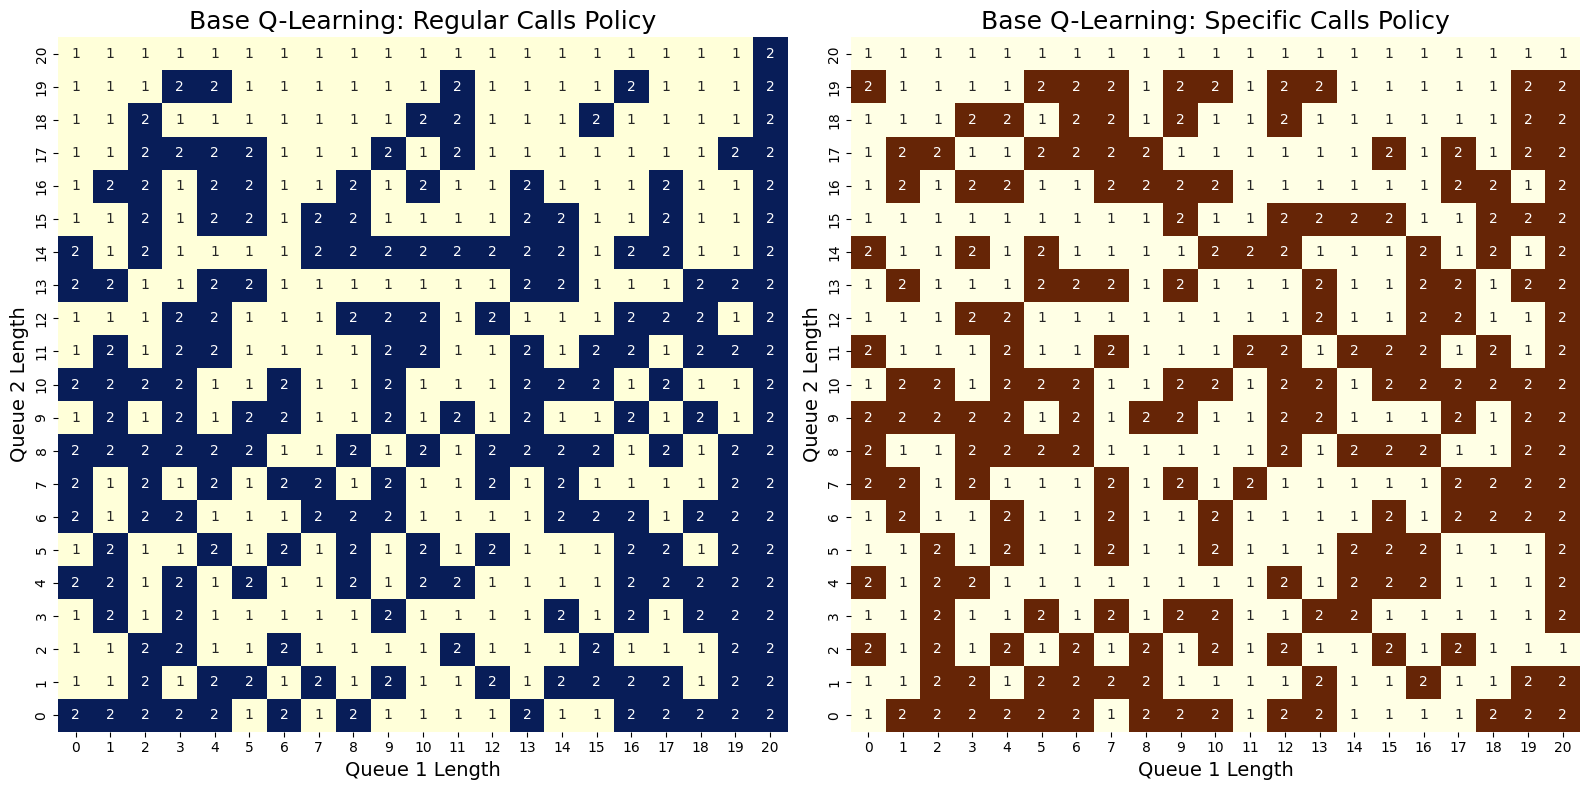

In [422]:
# Dimensions of the Q-tables
x_coords = [x for x, y in original_regular_q.keys()]
y_coords = [y for x, y in original_regular_q.keys()]

max_x = max(x_coords)
max_y = max(y_coords)
min_x = min(x_coords)
min_y = min(y_coords)

# Create a grid for plotting
def create_grid(q_table):
    grid = np.full((max_y - min_y + 1, max_x - min_x + 1), 0, dtype=int)  # Use -1 for missing, dtype=int
    for (x, y), action in q_table.items():
        grid[y - min_y, x - min_x] = int(round(action))
    return grid

ori_reg_grid = create_grid(original_regular_q)
ori_spec_grid = create_grid(original_specific_q)
enh_reg_grid = create_grid(enhanced_regular_q)
enh_spec_grid = create_grid(enhanced_specific_q)

# Plotting function
def plot_q_policies(grid_reg, grid_spec, title_reg, title_spec):
    # Change 0 to 1, 1 to 2 for plotting
    grid_reg_plot = np.where(grid_reg == 0, 1, 2)
    grid_spec_plot = np.where(grid_spec == 0, 1, 2)

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    sns.heatmap(
        grid_reg_plot,
        annot=True,
        fmt='.0f',
        cmap='YlGnBu',
        cbar=False,
        xticklabels=range(min_x, max_x + 1),
        yticklabels=range(min_y, max_y + 1),
        ax=axes[0]
    )
    axes[0].set_title(title_reg, fontsize=18)
    axes[0].set_xlabel('Queue 1 Length', fontsize=14)
    axes[0].set_ylabel('Queue 2 Length', fontsize=14)
    axes[0].invert_yaxis()
    sns.heatmap(
        grid_spec_plot,
        annot=True,
        fmt='.0f',
        cmap='YlOrBr',
        cbar=False,
        xticklabels=range(min_x, max_x + 1),
        yticklabels=range(min_y, max_y + 1),
        ax=axes[1]
    )
    axes[1].set_title(title_spec)
    axes[1].set_xlabel('Queue 1 Length', fontsize=14)
    axes[1].set_ylabel('Queue 2 Length', fontsize=14)
    axes[1].invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    
# Plot the policies
plot_q_policies(
    ori_reg_grid, ori_spec_grid,
    'Base Q-Learning: Regular Calls Policy',
    'Base Q-Learning: Specific Calls Policy'
)

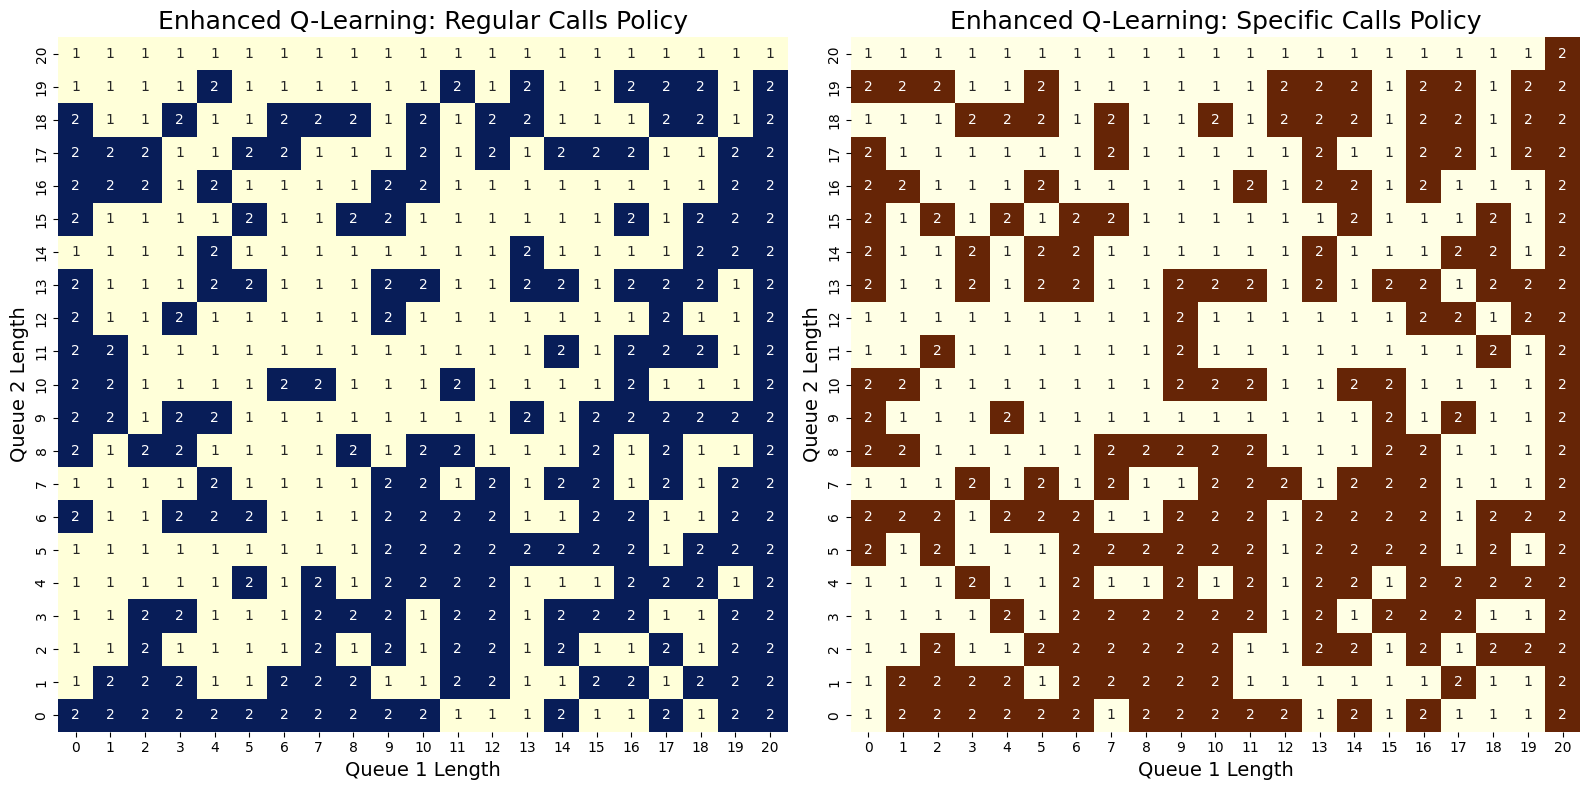

In [423]:
plot_q_policies(
    enh_reg_grid, enh_spec_grid,
    'Enhanced Q-Learning: Regular Calls Policy',
    'Enhanced Q-Learning: Specific Calls Policy'
)

In [359]:
enh_reg_grid

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1],
       [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1],
       [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1],
       [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,

In [396]:
# Calculate number of 1s and 0s in the enhanced regular policy
num_ones = np.sum(enh_reg_grid == 1)
num_zeros = np.sum(enh_reg_grid == 0)
print(f"Number of 0s in Enhanced Regular Policy: {num_zeros}")
print(f"Number of 1s in Enhanced Regular Policy: {num_ones}")

Number of 0s in Enhanced Regular Policy: 249
Number of 1s in Enhanced Regular Policy: 192


In [361]:
# Load the pickle files for queue parameters
with open('pickles/anonbank_lognorm_params.pkl', 'rb') as f:
    lognorm_params_df = pickle.load(f)
    
lognorm_params_dict = lognorm_params_df.set_index('param_name').T.to_dict()

with open('pickles/anonbank_service_rate.pkl', 'rb') as f:
    service_rate = pickle.load(f)

# Convert service_rate to a dictionary for easier access
ser_rate_dict = service_rate.set_index(['group', 'type_group'])[['mean_service_time', 'std']].to_dict('index')

In [362]:
# Global variables

# Queue size
MAX_QUEUE_SIZE = 20

# Arrival use the lognormal distribution parameters
ARRIVAL_REGULAR_MU = lognorm_params_dict['REGULAR']['mu']
ARRIVAL_REGULAR_SIGMA = lognorm_params_dict['REGULAR']['sigma']
ARRIVAL_REGULAR_LOC = lognorm_params_dict['REGULAR']['loc']
ARRIVAL_SPECIFIC_MU = lognorm_params_dict['SPECIFIC']['mu']
ARRIVAL_SPECIFIC_SIGMA = lognorm_params_dict['SPECIFIC']['sigma']
ARRIVAL_SPECIFIC_LOC = lognorm_params_dict['SPECIFIC']['loc']

# Service rate of agents use the service_rate dictionary
SERVICE_REGULAR_1 = ser_rate_dict[('1', 'REGULAR')]['mean_service_time']
SERVICE_SPECIFIC_1 = ser_rate_dict[('1', 'SPECIFIC')]['mean_service_time']
SERVICE_REGULAR_2 = ser_rate_dict[('2', 'REGULAR')]['mean_service_time']
SERVICE_SPECIFIC_2 = ser_rate_dict[('2', 'SPECIFIC')]['mean_service_time']

SERVICE_REGULAR_1_STD = ser_rate_dict[('1', 'REGULAR')]['std']
SERVICE_SPECIFIC_1_STD = ser_rate_dict[('1', 'SPECIFIC')]['std']
SERVICE_REGULAR_2_STD = ser_rate_dict[('2', 'REGULAR')]['std']
SERVICE_SPECIFIC_2_STD = ser_rate_dict[('2', 'SPECIFIC')]['std']

In [363]:
def get_policy_decision(policy_regular, policy_specific, q1, q2, call_type):
    """
    Get the policy decision based on the current state.
    returns the action to take (0 to agent1 or 1 to agent2).
    """
    
    # Ensure we don't exceed the maximum queue size
    q1 = min(q1, MAX_QUEUE_SIZE)
    q2 = min(q2, MAX_QUEUE_SIZE)
    
    if call_type == 'Regular':
        return policy_regular[q1, q2]
    else:
        return policy_specific[q1, q2]


def handle_call(env, policy_regular, policy_specific, call_type, agent1, agent2):
    """Handle the call from arrival to completion."""
    arrival_time = env.now
    
    # Get current queue sizes
    q1 = len(agent1.queue) + (1 if agent1.count > 0 else 0)
    q2 = len(agent2.queue) + (1 if agent2.count > 0 else 0)
    
    # Check if queues are full
    q1_full = q1 >= MAX_QUEUE_SIZE
    q2_full = q2 >= MAX_QUEUE_SIZE
    
    decision = get_policy_decision(policy_regular, policy_specific, q1, q2, call_type)
    
    # Route to selected queue if not full
    if decision == 0 and not q1_full:
        queue = agent1
    elif decision == 1 and not q2_full:
        queue = agent2
    elif not q1_full:
        queue = agent1
        decision = 0
    elif not q2_full:
        queue = agent2
        decision = 1
    else:
        # Both queues are full, drop the call
        agent_utilisations['Dropped Calls'] += 1
        print(f'{call_type} call dropped at {env.now}')
        return
    
    # Get into the queue and request service
    with queue.request() as req:
        yield req
        
        # Call is being served
        service_start_time = env.now
        waiting_time = service_start_time - arrival_time
        
        # Determine service time based on agent and call type
        if decision == 0:
            service_rate = 1/SERVICE_REGULAR_1 if call_type == 'Regular' else 1/SERVICE_SPECIFIC_1
        else:
            service_rate = 1/SERVICE_REGULAR_2 if call_type == 'Regular' else 1/SERVICE_SPECIFIC_2
            
        service_time = random.expovariate(service_rate)
        
        # Serve the call
        yield env.timeout(service_time)
        
        # Call completed
        completion_time = env.now
        total_time = completion_time - arrival_time
        
        # Record statistics
        waiting_times.append({
            'call_type': call_type,
            'queue': decision + 1,
            'arrival_time': arrival_time,
            'waiting_time': waiting_time,
            'service_time': service_time,
            'total_time': total_time
        })
        
        # Update agent utilisation
        agent_utilisations[f'Agent {decision + 1} {call_type}'] += 1

def regular_call_generator(env, policy_regular, policy_specific, queue1, queue2, scaler):
    """Generate regular calls according to a Poisson process."""
    while True:
        interarrival_time = random.lognormvariate(ARRIVAL_REGULAR_MU, ARRIVAL_REGULAR_SIGMA) + ARRIVAL_REGULAR_LOC
        interarrival_time /= scaler  # Scale the interarrival time
        yield env.timeout(interarrival_time)
        
        # Create a new call
        env.process(handle_call(env, policy_regular, policy_specific, 'Regular', queue1, queue2))
        
def specific_call_generator(env, policy_regular, policy_specific, queue1, queue2, scaler):
    """Generate specific calls according to a Poisson process."""
    while True:
        interarrival_time = random.lognormvariate(ARRIVAL_SPECIFIC_MU, ARRIVAL_SPECIFIC_SIGMA) + ARRIVAL_SPECIFIC_LOC
        interarrival_time /= scaler  # Scale the interarrival time
        yield env.timeout(interarrival_time)
        
        # Create a new call
        env.process(handle_call(env, policy_regular, policy_specific, 'Specific', queue1, queue2))
        
def record_queue_length(env, queue1, queue2):
    """Record the lengths of the queues at regular intervals."""
    while True:
        # Queue length includes the customer being served
        queue1_len = len(queue1.queue) + (1 if queue1.count > 0 else 0)
        queue2_len = len(queue2.queue) + (1 if queue2.count > 0 else 0)
        
        queue_lengths.append((
            queue1_len,
            queue2_len,
            env.now
        ))
        queue_length_times.append(env.now)
        
        yield env.timeout(0.1)

In [446]:
# Get results from the simulation
def get_results():
    """Compute and return the results of the simulation."""
    # Convert waiting times to DataFrame
    df_waiting = pd.DataFrame(waiting_times)
    
    # Calculate average metrics
    avg_waiting_time = df_waiting['waiting_time'].mean() if not df_waiting.empty else 0
    avg_service_time = df_waiting['service_time'].mean() if not df_waiting.empty else 0
    avg_total_time = df_waiting['total_time'].mean() if not df_waiting.empty else 0
    
    # Calculate metrics by call type
    avg_waiting_by_type = df_waiting.groupby('call_type')['waiting_time'].mean().to_dict() if not df_waiting.empty else {}
    avg_service_by_type = df_waiting.groupby('call_type')['service_time'].mean().to_dict() if not df_waiting.empty else {}
    
    # Calculate metrics by queue
    avg_waiting_by_queue = df_waiting.groupby('queue')['waiting_time'].mean().to_dict() if not df_waiting.empty else {}
    
    # Extract queue lengths and times
    queue_data = pd.DataFrame(queue_lengths, columns=['Queue 1 Length', 'Queue 2 Length', 'Time'])
    avg_queue_length = [queue_data['Queue 1 Length'].mean(), queue_data['Queue 2 Length'].mean()]
    
    # Calculate call volumes
    completed_calls = agent_utilisations['Agent 1 Regular'] + agent_utilisations['Agent 1 Specific'] + \
                    agent_utilisations['Agent 2 Regular'] + agent_utilisations['Agent 2 Specific']
    total_calls = completed_calls + agent_utilisations['Dropped Calls']
    
    call_counts = {
        'total': total_calls,
        'completed': completed_calls,
        'regular': agent_utilisations['Agent 1 Regular'] + agent_utilisations['Agent 2 Regular'],
        'specific': agent_utilisations['Agent 1 Specific'] + agent_utilisations['Agent 2 Specific'],
        'agent1': agent_utilisations['Agent 1 Regular'] + agent_utilisations['Agent 1 Specific'],
        'agent2': agent_utilisations['Agent 2 Regular'] + agent_utilisations['Agent 2 Specific'],
        'dropped': agent_utilisations['Dropped Calls'],
        'drop_rate': agent_utilisations['Dropped Calls'] / total_calls if total_calls > 0 else 0
        }
    
    # Combine all results into a dictionary
    results = {
        'call_counts': call_counts,
        'avg_waiting_time': avg_waiting_time,
        'avg_service_time': avg_service_time,
        'avg_total_time': avg_total_time,
        'avg_waiting_by_type': avg_waiting_by_type,
        'avg_service_by_type': avg_service_by_type,
        'avg_waiting_by_queue': avg_waiting_by_queue,
        'avg_queue_length': avg_queue_length,
        'waiting_times_df': df_waiting,
        'queue_data': queue_data
    }
    
    return results
    

# Run the simulation
def run_simulation(policy_regular, policy_specific, sim_time=1000, scaler=1.0, seed=1901448):
    """Run the simulation for a given time."""
    env = simpy.Environment()
    
    # Set random seed for reproducibility
    np.random.seed(seed)
    random.seed(seed)
    
    # Reset global variables
    global waiting_times, agent_utilisations, queue_lengths, queue_length_times
    waiting_times = []
    agent_utilisations = {'Agent 1 Regular': 0,
                            'Agent 1 Specific': 0,
                            'Agent 2 Regular': 0,
                            'Agent 2 Specific': 0,
                            'Dropped Calls': 0}
    queue_lengths = []
    queue_length_times = []
    
    agent1 = simpy.Resource(env, capacity=1)
    agent2 = simpy.Resource(env, capacity=1)
    
    # Start call generators
    env.process(regular_call_generator(env, policy_regular, policy_specific, agent1, agent2, scaler))
    env.process(specific_call_generator(env, policy_regular, policy_specific, agent1, agent2, scaler))
    
    # Start queue length recorder
    env.process(record_queue_length(env, agent1, agent2))
    
    # Run the simulation
    env.run(until=sim_time)
    
    # Get results
    results = get_results()
    return results
    
# Plotting functions

def plot_policies(policy_regular, policy_specific):
    """Plot the policies for regular and specific calls."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    sns.heatmap(policy_regular, cmap="YlGnBu", annot=True, fmt=".0f", cbar=False, ax=axes[0])
    axes[0].set_title('Policy for Regular Calls')
    axes[0].set_xlabel('Queue 2 Size')
    axes[0].set_ylabel('Queue 1 Size')
    axes[0].invert_yaxis()
    
    sns.heatmap(policy_specific, cmap="YlOrBr", annot=True, fmt=".0f", cbar=False, ax=axes[1])
    axes[1].set_title('Policy for Specific Calls')
    axes[1].set_xlabel('Queue 2 Size')
    axes[1].set_ylabel('Queue 1 Size')
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
def plot_queue_length_over_time(results):
    """Plot the queue lengths over time."""
    queue_data = results['queue_data']
    
    plt.figure(figsize=(12, 6))
    plt.plot(queue_data['Time'], queue_data['Queue 1 Length'], label='Queue 1 Length', color='blue')
    plt.plot(queue_data['Time'], queue_data['Queue 2 Length'], label='Queue 2 Length', color='orange')
    
    plt.title('Queue Lengths Over Time')
    plt.xlabel('Time')
    plt.ylabel('Queue Length')
    plt.legend()
    plt.grid()
    plt.show()
    
def plot_waiting_times_by_queue(results):
    """Plot the average waiting times by queue."""
    df_waiting = results['waiting_times_df']
    
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_waiting, x='queue', y='waiting_time')
    
    plt.title('Average Waiting Time by Queue')
    plt.xlabel('Queue')
    plt.ylabel('Average Waiting Time')
    plt.grid()
    plt.show()

In [466]:
# Set runtime for the simulation
RUNTIME = 3600  # Simulate for 1 hour (3600 seconds)
SCALER = 4.2  # Scale the interarrival times

# Run the simulation
results_ori = run_simulation(ori_reg_grid, ori_spec_grid, sim_time=RUNTIME, scaler=SCALER)
results_enh = run_simulation(enh_reg_grid, enh_spec_grid, sim_time=RUNTIME, scaler=SCALER)


Regular call dropped at 1550.0335724485365
Regular call dropped at 2620.556469261
Regular call dropped at 2630.208039241002
Regular call dropped at 2888.8982955705
Regular call dropped at 3072.3589355499903
Specific call dropped at 3074.8433198136277
Regular call dropped at 3081.6411716202756
Specific call dropped at 3122.3193776726503
Regular call dropped at 3213.561762033195
Regular call dropped at 3271.5589084072676
Regular call dropped at 2472.1801336004173
Regular call dropped at 2481.795199337442
Specific call dropped at 2483.4131027540398
Regular call dropped at 2501.0692654243044
Regular call dropped at 2510.6144673142353
Specific call dropped at 2649.844466913893
Regular call dropped at 2704.110034153452
Regular call dropped at 2713.829657391672
Specific call dropped at 3006.3304813184036
Regular call dropped at 3010.864409732859
Specific call dropped at 3242.5196105955206
Regular call dropped at 3243.630951157225
Specific call dropped at 3266.1812576957313
Regular call droppe

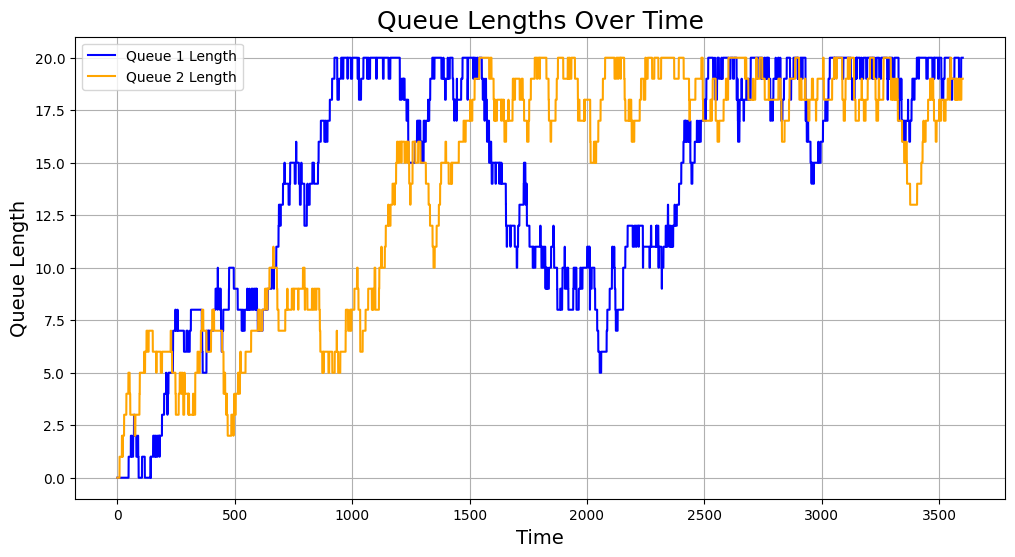

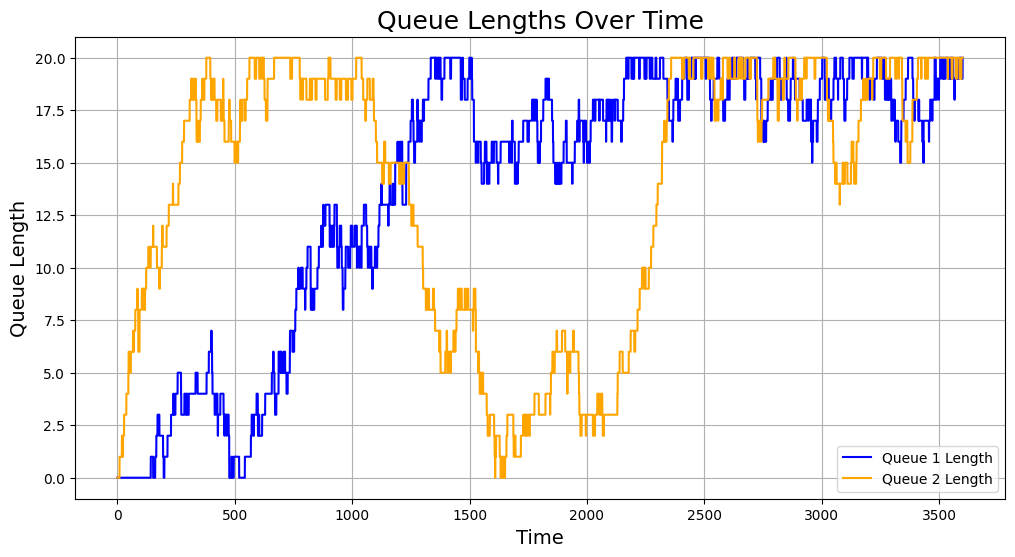

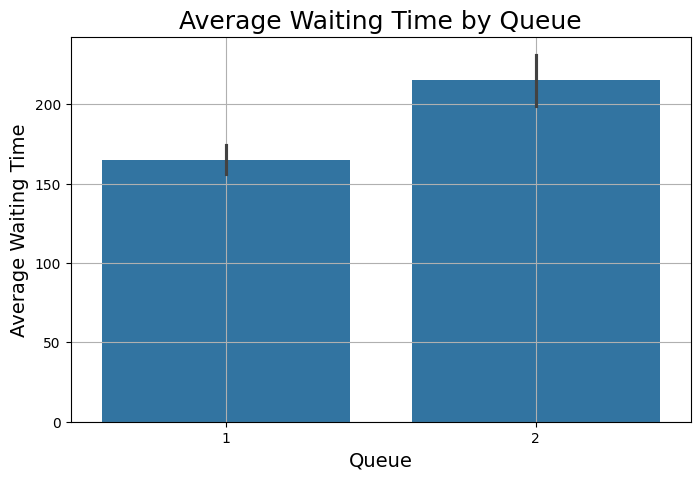

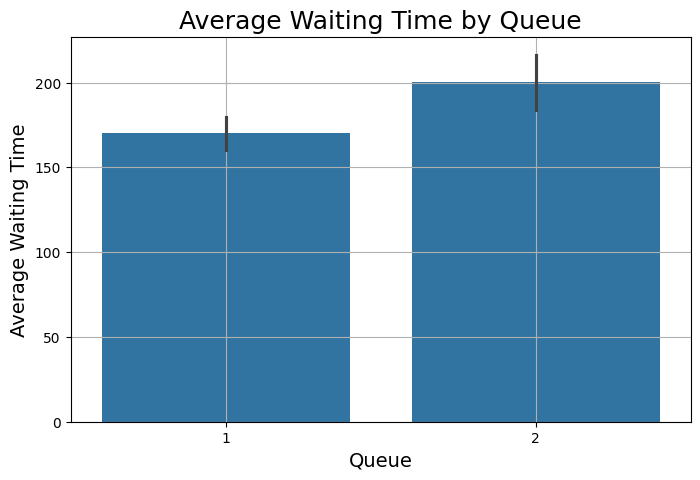

In [467]:
# Plot the results

plot_queue_length_over_time(results_ori)
plot_queue_length_over_time(results_enh)
plot_waiting_times_by_queue(results_ori)
plot_waiting_times_by_queue(results_enh)

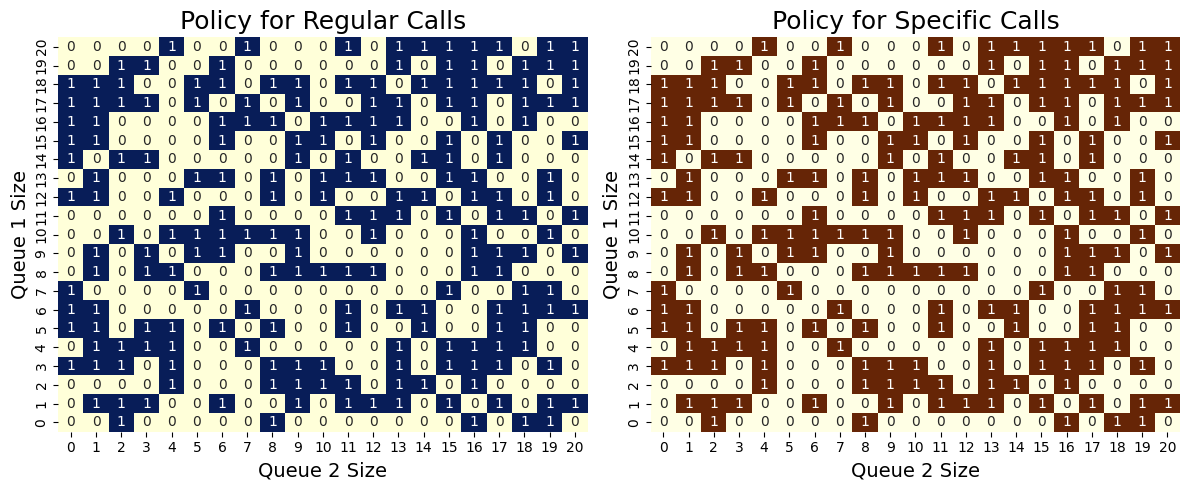

In [468]:
# Create another policy for comparison
# Route calls randomly
random.seed(42)  # For reproducibility
alt_regular_policy = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)
for i in range(MAX_QUEUE_SIZE + 1):
    for j in range(MAX_QUEUE_SIZE + 1):
        alt_regular_policy[i, j] = random.choice([0, 1])

random.seed(42)  # For reproducibility            
alt_specific_policy = np.ones((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)
for i in range(MAX_QUEUE_SIZE + 1):
    for j in range(MAX_QUEUE_SIZE + 1):
        alt_specific_policy[i, j] = random.choice([0, 1])
            
# Plot the new policies
plot_policies(alt_regular_policy, alt_specific_policy)

In [469]:
# Run the simulation
results_2 = run_simulation(alt_regular_policy, alt_specific_policy, sim_time=RUNTIME, scaler=SCALER)


Specific call dropped at 1417.9414783619457
Regular call dropped at 1427.9857004537598
Regular call dropped at 1437.5921792364375
Regular call dropped at 1446.779500968808
Regular call dropped at 1456.4350354122098
Regular call dropped at 2066.445397874688
Specific call dropped at 2104.9137807219836
Regular call dropped at 2113.9585237057877
Regular call dropped at 2123.424368256951
Specific call dropped at 2128.766874713591
Regular call dropped at 2133.2075830984936
Regular call dropped at 2142.306858750353
Regular call dropped at 2152.0152414313593
Specific call dropped at 2152.50350332177
Regular call dropped at 2161.507841918683
Regular call dropped at 2257.6396136856047
Specific call dropped at 2318.481141060943
Regular call dropped at 2343.917434893197
Regular call dropped at 2363.1568166432294
Specific call dropped at 2366.3067381899355
Regular call dropped at 2468.3855205903683
Regular call dropped at 2620.5324789726164
Specific call dropped at 2626.3955919871833
Regular call d

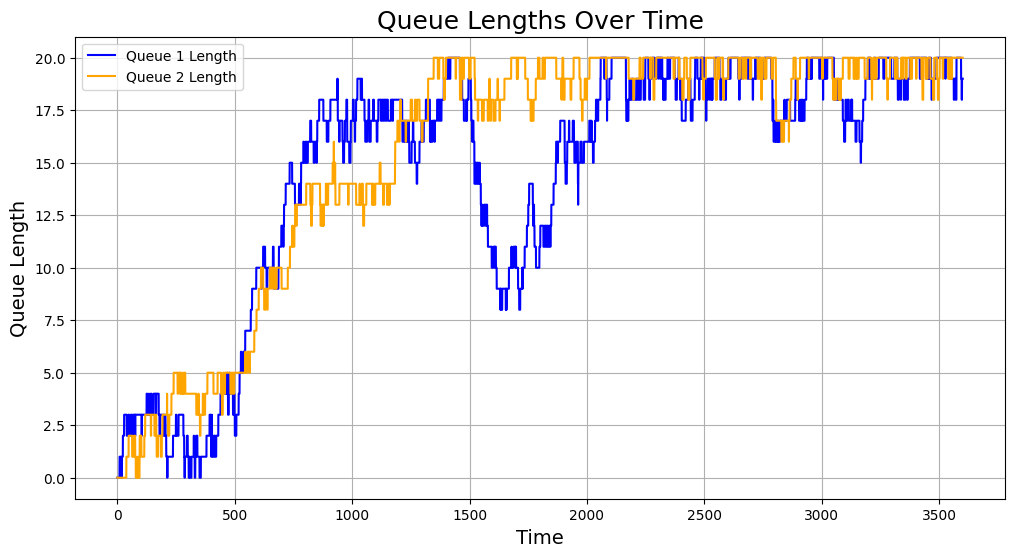

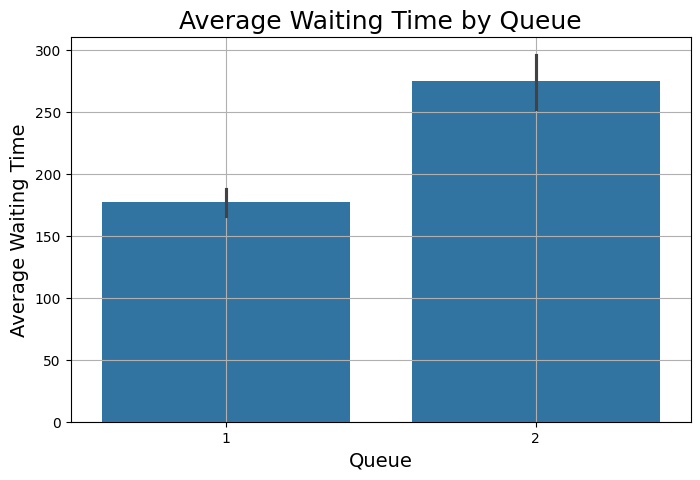

In [470]:
# Plot the results

plot_queue_length_over_time(results_2)
plot_waiting_times_by_queue(results_2)

In [471]:
def metrics_df(results_a, results_b):
    """Create a metrics comparison DataFrame for two sets of results."""
    df = pd.DataFrame({
        'Metric': ['Average Waiting Time', 'Average Service Time', 'Average Total Time',
                    'Average Waiting Time Regular', 'Average Waiting Time Specific',
                    'Average Waiting Time Queue 1', 'Average Waiting Time Queue 2',
                'Average Queue Length 1', 'Average Queue Length 2'],
        'First Policy': [results_a['avg_waiting_time'], results_a['avg_service_time'], results_a['avg_total_time'],
                           results_a['avg_waiting_by_type']['Regular'], results_a['avg_waiting_by_type']['Specific'],
                           results_a['avg_waiting_by_queue'][1], results_a['avg_waiting_by_queue'][2],
                        results_a['avg_queue_length'][0], results_a['avg_queue_length'][1]],
        'Second Policy': [results_b['avg_waiting_time'], results_b['avg_service_time'], results_b['avg_total_time'],
                           results_b['avg_waiting_by_type']['Regular'], results_b['avg_waiting_by_type']['Specific'],
                           results_b['avg_waiting_by_queue'][1], results_b['avg_waiting_by_queue'][2],
                    results_b['avg_queue_length'][0], results_b['avg_queue_length'][1]]
    })
    df.set_index('Metric', inplace=True)
    df['Delta'] = df['First Policy'] - df['Second Policy']
    
    return df

In [472]:
ori_enh_df = metrics_df(results_ori, results_enh)
enh_rd_df = metrics_df(results_enh, results_2)
rd_ori_df = metrics_df(results_2, results_ori)

print("Original vs Enhanced Policy Metrics:")
print(ori_enh_df)
print("\nEnhanced vs Random Policy Metrics:")
print(enh_rd_df)
print("\nRandom vs Original Policy Metrics:")
print(rd_ori_df)

Original vs Enhanced Policy Metrics:
                               First Policy  Second Policy      Delta
Metric                                                               
Average Waiting Time             187.074480     183.706341   3.368139
Average Service Time              14.738033      14.724415   0.013617
Average Total Time               201.812513     198.430756   3.381757
Average Waiting Time Regular     187.321300     184.166721   3.154579
Average Waiting Time Specific    186.468973     182.541647   3.927326
Average Waiting Time Queue 1     164.924281     170.388267  -5.463986
Average Waiting Time Queue 2     215.313359     200.385642  14.927717
Average Queue Length 1            14.196328      13.952779   0.243549
Average Queue Length 2            14.146107      13.867726   0.278381

Enhanced vs Random Policy Metrics:
                               First Policy  Second Policy      Delta
Metric                                                               
Average Waiting T

In [473]:
def volume_df(results_a, results_b):
    """Create a volume comparison DataFrame for two sets of results."""
    df = pd.DataFrame({
        'Metric': ['Total Calls', 'Completed Calls',
                'Agent 1 Calls', 'Agent 2 Calls', 'Dropped Calls'],
        'Optimal Policy': [results_a['call_counts']['total'], results_a['call_counts']['completed'],
                        results_a['call_counts']['agent1'], results_a['call_counts']['agent2'],
                        results_a['call_counts']['dropped']],
        'Generated Policy': [results_b['call_counts']['total'], results_b['call_counts']['completed'],
                            results_b['call_counts']['agent1'], results_b['call_counts']['agent2'],
                            results_b['call_counts']['dropped']]
    })
    df.set_index('Metric', inplace=True)
    df['Delta'] = df['Optimal Policy'] - df['Generated Policy']
    
    return df

In [474]:
ori_enh_df = volume_df(results_ori, results_enh)
enh_rd_df = volume_df(results_enh, results_2)

print("Original vs Enhanced Policy Metrics:")
print(ori_enh_df)
print("\nEnhanced vs Random Policy Metrics:")
print(enh_rd_df)

Original vs Enhanced Policy Metrics:
                 Optimal Policy  Generated Policy  Delta
Metric                                                  
Total Calls                 490               488      2
Completed Calls             480               473      7
Agent 1 Calls               269               263      6
Agent 2 Calls               211               210      1
Dropped Calls                10                15     -5

Enhanced vs Random Policy Metrics:
                 Optimal Policy  Generated Policy  Delta
Metric                                                  
Total Calls                 488               490     -2
Completed Calls             473               438     35
Agent 1 Calls               263               260      3
Agent 2 Calls               210               178     32
Dropped Calls                15                52    -37


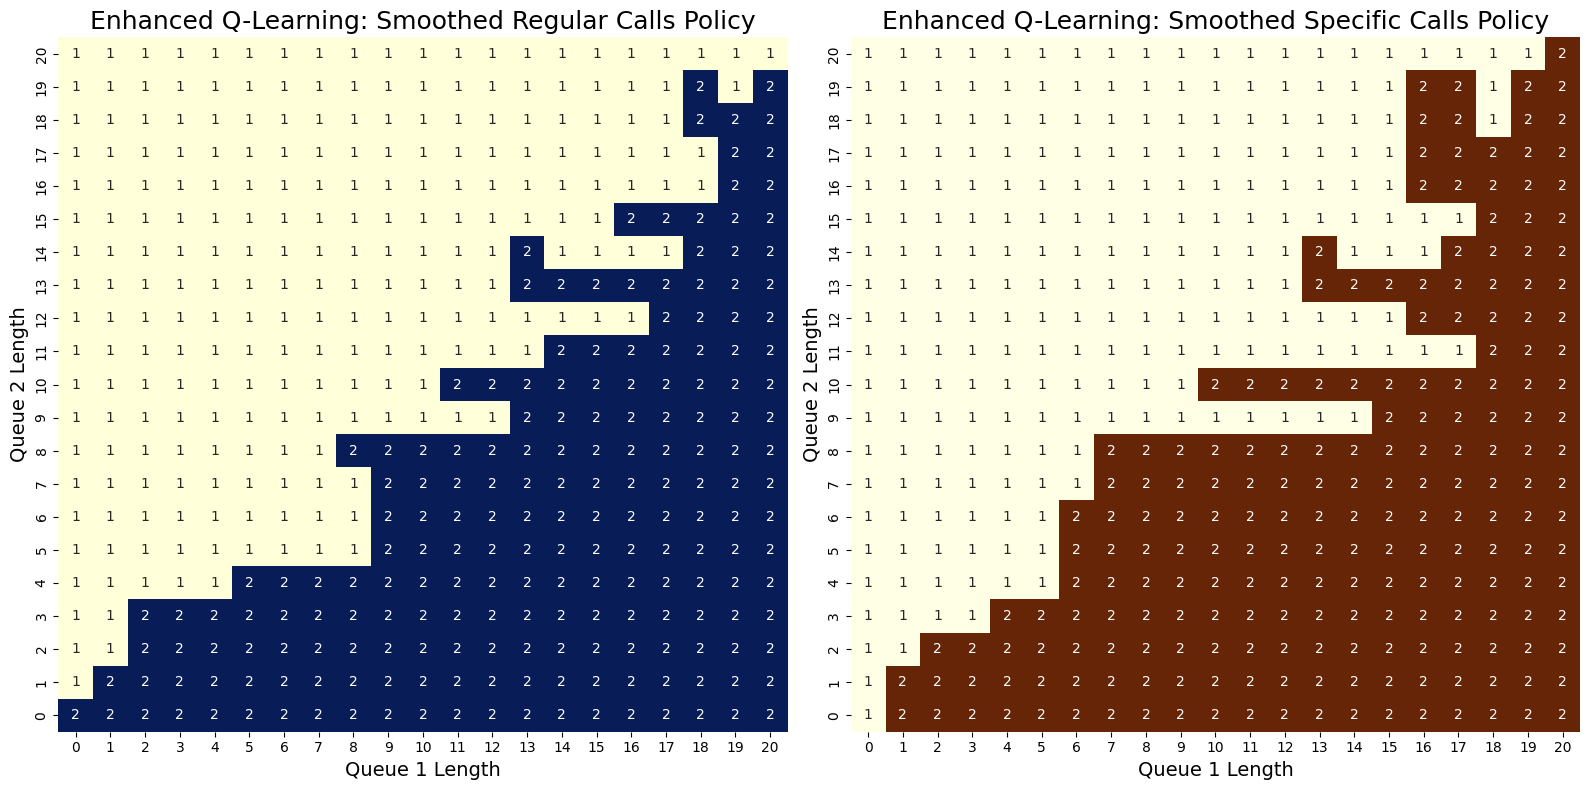

In [475]:
# Smooth out the grids
# For each x=y, if (x,y)=0, fill along y-axis to y=len(y) with 0s. If (x,y)=1, fill along x axis to x=0 with 1s

def smooth_diagonal_array(arr):
    """
    Diagonal smoothing based on diagonal elements.
    - If diagonal element (i,i) = 0, fill entire column i with 0s
    - If diagonal element (i,i) = 1, fill row i from position i to 0 with 1s
    """
    smoothed = arr.copy()
    n_rows, n_cols = arr.shape
    n = min(n_rows, n_cols)
    
    # Process main diagonal elements (where queue lengths are equal)
    for i in range(n):
        if i < n_rows and i < n_cols:
            diagonal_value = arr[i, i]
            
            if diagonal_value == 0:
                # Fill from this position down (y-axis) to bottom with 0s
                smoothed[i:, i] = 0
                # Find the next 1 along x-axis and fill with 1s
                for j in range(i + 1, n_cols):
                    if arr[i, j] == 1:
                        smoothed[i, j+1:] = 1
                        break
            else:  # diagonal_value == 1
                # Fill from this position left (x-axis) to x=0 with 1s
                smoothed[i, i+1:] = 1
                # Find the next 0 along y-axis and fill with 0s
                for j in range(i + 1, n_rows):
                    if arr[j, i] == 0:
                        smoothed[j:, i] = 0
                        break
    
    return smoothed

smooth_reg_grid = smooth_diagonal_array(enh_reg_grid)
smooth_spec_grid = smooth_diagonal_array(enh_spec_grid)

plot_q_policies(
    smooth_reg_grid, smooth_spec_grid,
    'Enhanced Q-Learning: Smoothed Regular Calls Policy',
    'Enhanced Q-Learning: Smoothed Specific Calls Policy'
)

Regular call dropped at 1522.877590783882
Regular call dropped at 3149.7137515059735
Regular call dropped at 3559.4077226001236


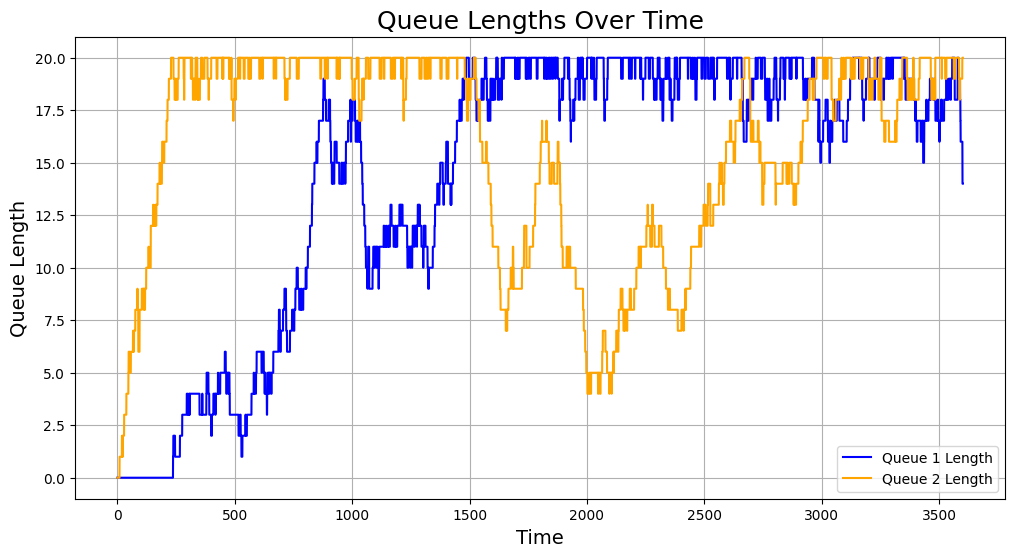

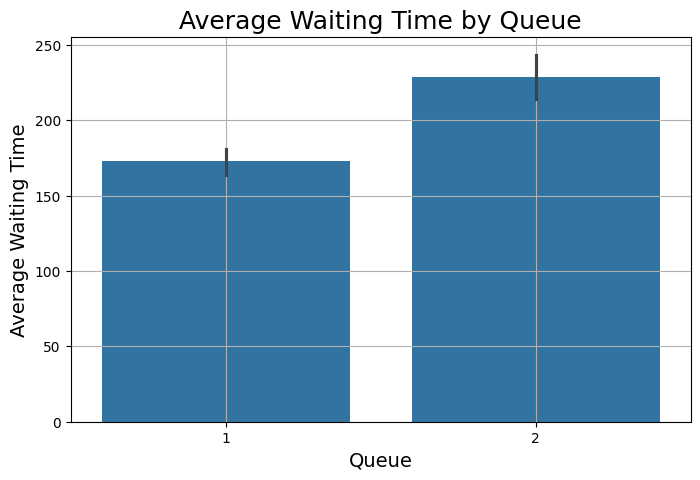

In [476]:
results_smooth = run_simulation(smooth_reg_grid, smooth_spec_grid, sim_time=RUNTIME, scaler=SCALER)
# Plot the results for smoothed policies
plot_queue_length_over_time(results_smooth)
plot_waiting_times_by_queue(results_smooth)

In [477]:
smo_enh_df = metrics_df(results_smooth, results_enh)
print("Smoothed vs Enhanced Policy Metrics:")
print(smo_enh_df)

Smoothed vs Enhanced Policy Metrics:
                               First Policy  Second Policy      Delta
Metric                                                               
Average Waiting Time             197.518839     183.706341  13.812498
Average Service Time              14.130461      14.724415  -0.593954
Average Total Time               211.649300     198.430756  13.218544
Average Waiting Time Regular     201.540128     184.166721  17.373408
Average Waiting Time Specific    187.536914     182.541647   4.995267
Average Waiting Time Queue 1     172.771959     170.388267   2.383691
Average Waiting Time Queue 2     228.766051     200.385642  28.380410
Average Queue Length 1            14.424322      13.952779   0.471542
Average Queue Length 2            15.741535      13.867726   1.873809


In [478]:
smo_enh_df = volume_df(results_smooth, results_enh)
print("Smoothed vs Enhanced Policy Volumes:")
print(smo_enh_df)

Smoothed vs Enhanced Policy Volumes:
                 Optimal Policy  Generated Policy  Delta
Metric                                                  
Total Calls                 494               488      6
Completed Calls             491               473     18
Agent 1 Calls               274               263     11
Agent 2 Calls               217               210      7
Dropped Calls                 3                15    -12
